### Define Functions

In [22]:
import scipy.signal
from scipy.signal import butter, filtfilt, resample, hilbert
import pywt
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
import librosa

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def wavelet_denoise(data, wavelet='db4', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    coeffs[1] = np.zeros_like(coeffs[1])  # Remove D1
    coeffs[3] = np.zeros_like(coeffs[3])  # Remove D3
    denoised = pywt.waverec(coeffs, wavelet)
    return denoised

def envelope_find_peaks(denoised, window_size=50):
    envelope = np.abs(hilbert(denoised))   
    envelope = gaussian_filter1d(envelope, sigma=20)  
    kernel = np.ones(window_size) / window_size
    smoothed_envelope = np.convolve(envelope, kernel, mode='same')
    peaks, _ = scipy.signal.find_peaks(smoothed_envelope, distance=200)
    threshold = np.median(smoothed_envelope) + 0.1 * np.std(smoothed_envelope)
    peaks = peaks[smoothed_envelope[peaks] > threshold]
    return smoothed_envelope, peaks

def peak_s1_s2(peaks):
    intervals = np.diff(peaks)
    labels = []  
    if intervals[0] < intervals[1]:
        labels.append('S1')
        labels.append('S2')
    else:
        labels.append('S2')
        labels.append('S1')

    for i in range(1, len(intervals)):
        last_interval = intervals[i - 1]
        current_interval = intervals[i]
        if current_interval > last_interval:
            next_label = 'S1'
        else:
            next_label = 'S2'
        labels.append(next_label)

    if len(labels) < len(peaks):
        labels.append('S1' if labels[-1] == 'S2' else 'S2')
    labeled_peaks = list(zip(peaks, labels))
    return labeled_peaks

def signal_peaks(data, envelope, peaks ,target_sr, plot=False):
    segments = []
    window_around_peak_ms = 100  
    window_samples = int(window_around_peak_ms * target_sr / 1000)  

    for peak_idx in peaks:
        start_sample = max(0, peak_idx - window_samples)
        end_sample = min(len(envelope) - 1, peak_idx + window_samples)
        peak_amplitude = envelope[peak_idx]
        segments.append((start_sample, end_sample, peak_idx, peak_amplitude))

    labeled_peaks = peak_s1_s2(peaks)
    if plot == False:
        return segments, labeled_peaks

    time_vec = np.arange(len(data)) / target_sr  # Time vector for x-axis
    plt.figure(figsize=(15, 4))
    plt.plot(time_vec, data)
    
    for p, label in labeled_peaks:
        plt.axvline(p/1000, color='r' if label == 'S1' else 'g', linestyle='--', alpha=0.6)
        plt.text(p/1000, data[p], label, color='k', fontsize=8, ha='center')

    for start, end, peak_idx, peak_amplitude in segments:
        plt.axvspan(start/1000, end/1000, color='pink', alpha=0.3)

    plt.grid(True)
    plt.title("PCG Signal with Detected Peaks")
    plt.xlabel("Time (sec)")
    plt.ylabel("Amplitude")
    plt.show()

    return segments, labeled_peaks

In [23]:
def match_labels(labeled_peaks, gt_s1, gt_s2):
    pred_s1 = [s for s, label in labeled_peaks if label == 'S1']
    pred_s2 = [s for s, label in labeled_peaks if label == 'S2']

    def count_matches(pred, gt):
        matched_gt = set()
        tp = 0
        for p in pred:
            for g in gt:
                if abs(p - g) <= tolerance and g not in matched_gt:
                    tp += 1
                    matched_gt.add(g)
                    break
        return tp, len(pred), len(gt)  # true positives, predicted, ground truth

    s1_tp, s1_p, s1_gt = count_matches(pred_s1, gt_s1)
    s2_tp, s2_p, s2_gt = count_matches(pred_s2, gt_s2)

    return {
        'S1': {'TP': s1_tp, 'Predicted': s1_p, 'GroundTruth': s1_gt},
        'S2': {'TP': s2_tp, 'Predicted': s2_p, 'GroundTruth': s2_gt},
    }

def compute_metrics(match_info):
    metrics = {}
    for label in ['S1', 'S2']:
        tp = match_info[label]['TP']
        p = match_info[label]['Predicted']
        gt = match_info[label]['GroundTruth']
        match_rate = tp / gt if gt > 0 else 0
        precision = tp / p if p > 0 else 0
        recall = tp / gt if gt > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
        metrics[label] = {
            'n_true_positive': tp,
            'n_predicted': p,
            'n_ground_truth': gt,
            'match_rate': match_rate,
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        }
    return metrics

### Run Script

murmur


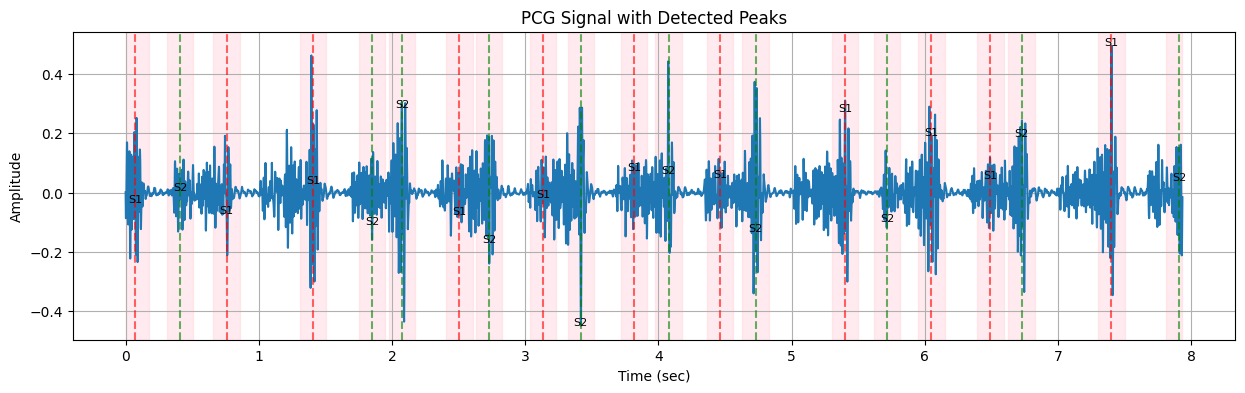

Error processing 201104021355.wav: index 1 is out of bounds for axis 0 with size 1
murmur


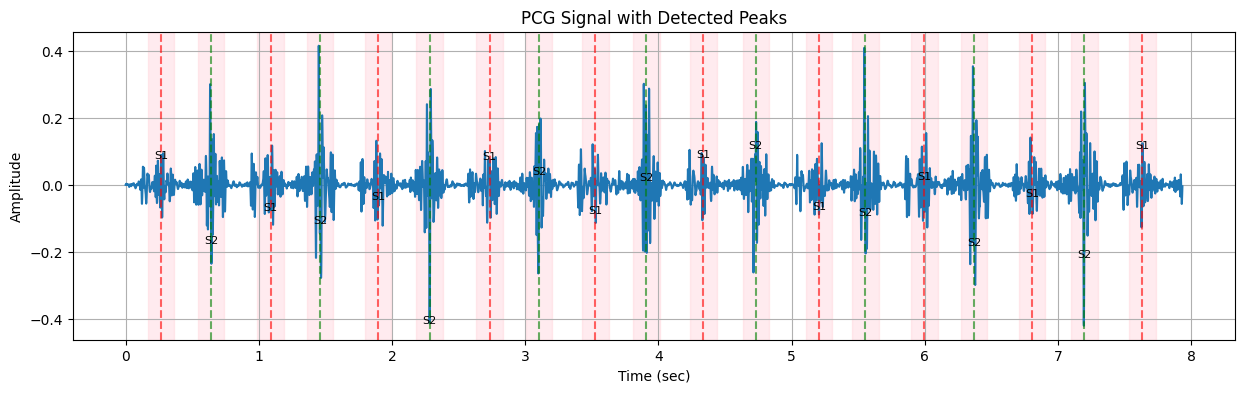

healthy


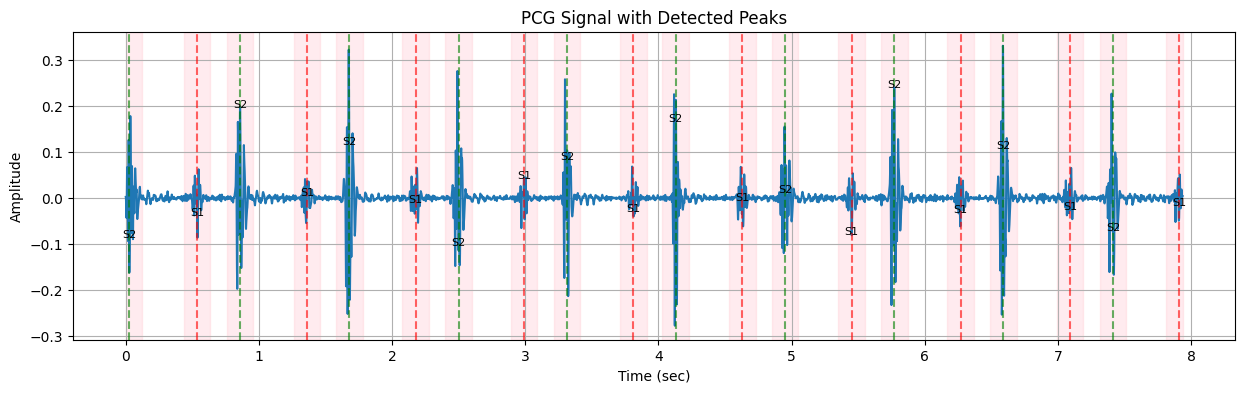

artifact


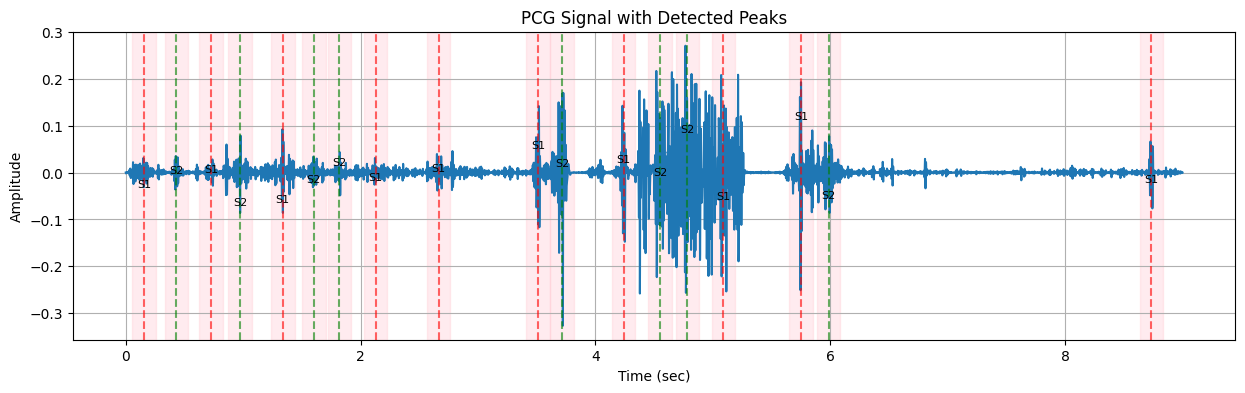

Error processing 201106121445.wav: index 1 is out of bounds for axis 0 with size 1


,filename,n_S1,n_S2,samples_S1,samples_S2,data,s1_s2_intervals,s2_s1_intervals
0,201108222253.wav,11,10,"[72, 759, 1407, 2506, 3133, 3817, 4464, 5401, ...","[408, 1849, 2075, 2729, 3418, 4078, 4730, 5716...","[-0.1317180016890312, -0.25474850183173564, -0...","[336, 442, 223, 285, 261, 266, 315, 235, 509]","[351, 431, 404, 399, 386, 671, 334, 674]"
1,201101051108.wav,11,11,"[58, 979, 1916, 2834, 3395, 3732, 4639, 5547, ...","[330, 1275, 2215, 3111, 4027, 4935, 5834, 6753...","[-0.001550461739475901, -0.003286934433796538,...","[272, 296, 299, 277, 295, 296, 287, 278, 288, ...","[649, 641, 619, 284, 612, 612, 641, 661, 650]"
2,201108222252.wav,11,11,"[563, 1376, 2174, 2663, 3479, 4023, 4633, 5478...","[179, 875, 1628, 1836, 3038, 4291, 4915, 5118,...","[0.08035318494512443, 0.17784670038068662, 0.1...","[312, 252, 375, 268, 282, 353, 237, 272]","[384, 501, 338, 441, 342, 360, 438, 242]"
3,201108222246.wav,10,9,"[386, 1208, 2029, 2844, 3667, 4480, 5304, 6124...","[706, 1534, 2348, 3170, 3988, 4800, 5620, 6443...","[-0.02263121106994222, -0.04565681731106771, -...","[320, 326, 319, 326, 321, 320, 316, 319, 322]","[502, 495, 496, 497, 492, 504, 504, 498, 497]"
4,201108222245.wav,8,8,"[668, 1694, 2719, 3743, 4764, 5791, 6813, 7836]","[25, 1010, 2034, 3057, 4081, 5105, 6129, 7153]","[-0.14325433210636046, -0.27856339122660023, -...","[342, 340, 338, 338, 341, 338, 340]","[643, 684, 685, 686, 683, 686, 684, 683]"
...,...,...,...,...,...,...,...,...
100,201106121242.wav,11,14,"[1452, 2426, 3130, 3603, 4023, 4845, 5933, 641...","[962, 1883, 2108, 2684, 3343, 4421, 5172, 5433...","[-0.11794252305258723, -0.2687577586538259, 0....","[431, 258, 213, 398, 327, 386, 235, 295]","[490, 318, 446, 260, 424, 282, 381, 343, 257]"
101,201105040918.wav,8,8,"[4407, 4920, 5383, 5665, 6406, 6945, 7516, 8605]","[4649, 5147, 5891, 6112, 6675, 7985, 8200, 8813]","[-1.6589866809953313e-05, 3.4995400490581744e-...","[242, 227, 226, 269, 469, 208]","[271, 236, 294, 270, 405]"
102,201106121445.wav,0,0,[],[],"[-0.0012005319131681343, 0.0005147945002106322...",[],[]
103,201106040722.wav,12,13,"[127, 886, 1600, 2292, 3058, 3816, 4532, 5259,...","[461, 1202, 1926, 2643, 3409, 4152, 4867, 5595...","[0.06266934033242248, -0.0038281686135168886, ...","[334, 316, 326, 351, 351, 336, 335, 336, 319, ...","[425, 398, 366, 415, 407, 380, 392, 399, 421, ..."


In [25]:
metadata = pd.read_pickle("feature_metadata.pkl")

target_sr = 1000
tolerance = int(0.1 * target_sr)  # 100 ms tolerance

processed_rows = []

for idx, row in metadata.iterrows():
    filename = row['filename']
    signal = row['data']

    try:
        # Signal pipeline
        data = bandpass_filter(signal, 20, 200, target_sr, order=2)
        denoised = wavelet_denoise(data, wavelet='db4', level=4)
        denoised = bandpass_filter(denoised, 20, 200, target_sr, order=2)
        envelope, peaks = envelope_find_peaks(denoised, window_size=50)
        if idx % 30 == 0:
            print(row['label'])
            segments, labeled_peaks = signal_peaks(denoised, envelope, peaks, target_sr, plot=True)
        else:
            segments, labeled_peaks = signal_peaks(denoised, envelope, peaks, target_sr, plot=False)

        # Extract predicted S1/S2 samples
        samples_S1 = [p for p, label in labeled_peaks if label == 'S1']
        samples_S2 = [p for p, label in labeled_peaks if label == 'S2']

        # Sort just in case
        samples_S1.sort()
        samples_S2.sort()

        # Compute intervals
        all_samples = sorted(samples_S1 + samples_S2)
        diffs = np.diff(all_samples)

        s1_s2_intervals = []
        s2_s1_intervals = []

        for i in range(len(all_samples) - 1):
            if all_samples[i] in samples_S1 and all_samples[i+1] in samples_S2:
                s1_s2_intervals.append(all_samples[i+1] - all_samples[i])
            elif all_samples[i] in samples_S2 and all_samples[i+1] in samples_S1:
                s2_s1_intervals.append(all_samples[i+1] - all_samples[i])

        processed_rows.append({
            'filename': filename,
            'n_S1': len(samples_S1),
            'n_S2': len(samples_S2),
            'samples_S1': samples_S1,
            'samples_S2': samples_S2,
            'data': signal,
            's1_s2_intervals': s1_s2_intervals,
            's2_s1_intervals': s2_s1_intervals
        })

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        processed_rows.append({
            'filename': filename,
            'n_S1': 0,
            'n_S2': 0,
            'samples_S1': [],
            'samples_S2': [],
            'data': signal,
            's1_s2_intervals': [],
            's2_s1_intervals': []
        })

s1_s2_data = pd.DataFrame(processed_rows)
s1_s2_data

In [18]:
from classify_s1_s2 import HeartSoundS1S2 as hss
import pandas as pd

metadata = pd.read_pickle("feature_metadata.pkl")

for idx, row in metadata.iterrows():
    filename = row['filename']
    signal = row['data']
    break

s1s2_classifier = hss()
results = s1s2_classifier.classify(signal)
print('S1 Samples: {}'.format(results['samples_S1']))
print('S2 Samples: {}'.format(results['samples_S2']))

S1 Samples: [np.int64(76), np.int64(755), np.int64(1408), np.int64(2506), np.int64(3133), np.int64(3817), np.int64(4463), np.int64(5402), np.int64(6055), np.int64(6493), np.int64(7400)]
S2 Samples: [np.int64(411), np.int64(1850), np.int64(2077), np.int64(2731), np.int64(3421), np.int64(4074), np.int64(4732), np.int64(5716), np.int64(6730), np.int64(7911)]


### Compute Metrics

In [ ]:
metadata = metadata[metadata['in_df'] == True].reset_index(drop=True)
metadata = metadata[['filename', 'n_S1', 'n_S2', 'samples_S1',
       'samples_S2', 'data', 's1_s2_intervals',
       's2_s1_intervals']]
       

results = []

for idx, row in metadata.iterrows():
    signal = row['data']
    gt_s1 = row['samples_S1']
    gt_s2 = row['samples_S2']
    filename = row['filename']

    # Run your full pipeline
    data = bandpass_filter(signal, 20, 200, target_sr, order=2)
    denoised = wavelet_denoise(data, wavelet='db4', level=4)
    denoised = bandpass_filter(denoised, 20, 200, target_sr, order=2)
    envelope, peaks = envelope_find_peaks(denoised, window_size=50)
    segments, labeled_peaks = signal_peaks(denoised, envelope, peaks, target_sr, plot=False)

    # Evaluate
    match_info = match_labels(labeled_peaks, gt_s1, gt_s2)
    metrics = compute_metrics(match_info)

    # Store results
    results.append({
        'filename': filename,
        'S1_nPred': metrics['S1']['n_predicted'],
        'S1_nGT': metrics['S1']['n_ground_truth'],
        'S1_TP': metrics['S1']['n_true_positive'],

        'S2_nPred': metrics['S2']['n_predicted'],
        'S2_nGT': metrics['S2']['n_ground_truth'],
        'S2_TP': metrics['S2']['n_true_positive'],
        
        'S1_MatchRate': metrics['S1']['match_rate'],
        'S2_MatchRate': metrics['S2']['match_rate'],
        'S1_Precision': metrics['S1']['Precision'],
        'S1_Recall': metrics['S1']['Recall'],
        'S1_F1': metrics['S1']['F1'],
        'S2_Precision': metrics['S2']['Precision'],
        'S2_Recall': metrics['S2']['Recall'],
        'S2_F1': metrics['S2']['F1']

    })

In [5]:
pd.DataFrame(results)

,filename,S1_nPred,S1_nGT,S1_TP,S2_nPred,S2_nGT,S2_TP,S1_MatchRate,S2_MatchRate,S1_Precision,S1_Recall,S1_F1,S2_Precision,S2_Recall,S2_F1
0,201106141148.wav,11,9,7,8,10,7,0.777778,0.700000,0.636364,0.777778,0.700000,0.875000,0.700000,0.777778
1,201102081321.wav,14,12,12,13,14,13,1.000000,0.928571,0.857143,1.000000,0.923077,1.000000,0.928571,0.962963
2,201103140132.wav,10,3,2,9,4,2,0.666667,0.500000,0.200000,0.666667,0.307692,0.222222,0.500000,0.307692
3,201106210943.wav,9,6,6,7,7,5,1.000000,0.714286,0.666667,1.000000,0.800000,0.714286,0.714286,0.714286
4,201106221418.wav,10,9,8,9,10,8,0.888889,0.800000,0.800000,0.888889,0.842105,0.888889,0.800000,0.842105
5,201105021654.wav,9,7,3,8,7,4,0.428571,0.571429,0.333333,0.428571,0.375000,0.500000,0.571429,0.533333
6,201103221214.wav,5,2,1,6,3,1,0.500000,0.333333,0.200000,0.500000,0.285714,0.166667,0.333333,0.222222
7,201105011626.wav,13,20,9,10,18,5,0.450000,0.277778,0.692308,0.450000,0.545455,0.500000,0.277778,0.357143
8,201108011118.wav,12,11,11,12,11,11,1.000000,1.000000,0.916667,1.000000,0.956522,0.916667,1.000000,0.956522
9,201106221450.wav,11,11,9,13,10,9,0.818182,0.900000,0.818182,0.818182,0.818182,0.692308,0.900000,0.782609
